# Compare output of routing providers

In this example, we'll show you how easy it is to compare different routing providers with `routingpy`. We'll request **directions**, **isochrones** and **matrices** for all currently implemented routing engines and plot the output.

*Note*, you'll have to have the appropriate API keys or comment out the providers you're not interested in.

In [3]:
from itertools import chain
from matplotlib import pyplot as plt
import pandas as pd
#import geopandas as gpd
import random
from shapely.geometry import box, Point, LineString, Polygon, MultiPolygon
import contextily as cx

from routingpy.routers import get_router_by_name

BASEMAP_SOURCE = cx.providers.CartoDB.Positron
HEX_ALPHA = "4F"
POINT_PLOT_KWDS = {"marker": "D", "color": "black", "markersize": 20}
plt.rcParams['figure.dpi'] = 50

## TOC

- **[Preparation](#Create-random-routes)**
- **[Calculate Directions](#Calculate-Directions)**
- **[Calculate Isochrones](#Calculate-Isochrones)**
- **[Calculate Matrix](#Calculate-Matrix)**

### Create random routes

Let's start by creating randomly chosen coordinate pairs within a bounding box (in this case Berlin). You can specify the amount of coordinate pairs (i.e. routes) and their distance ranges from *start* to *destination*.

In [4]:
# We'll need the bounding box throughout the notebook
bbox = [13.280066,52.459562,13.507532,52.576611]  # bbox Berlin
minx, miny, maxx, maxy = bbox
poly_berlin = box(*bbox)

def random_coordinates(n, min_dist, max_dist):
    assert min_dist < max_dist # make sure parameters are valid
    
    coordinates = []
    for _ in range(n):
        counter = 0
        in_poly = False
        while not in_poly:
            counter += 1
            x = random.uniform(minx, maxx)
            y = random.uniform(miny, maxy)
            p = Point(x, y)
            if poly_berlin.contains(p):
                # Make sure all route segments are within limits
                if coordinates:
                    if not min_dist < p.distance(Point(coordinates[-1])) < max_dist:
                        continue
                coordinates.append([x, y])
                in_poly = True
            if counter > 1000:
                raise ValueError("Distance settings are too restrictive. Try a wider range and remember it's in degrees.")

    return coordinates

### Define all router clients

First we need to setup our router clients, i.e. provide the API keys, and specify which profile you want to route from. In this case, we chose **car**.

If you don't want to compare that many providers, simply comment out the ones you don't want to calculate.

In [6]:
routers = {
    'ors': {
        'api_key': '',
        'display_name': 'OpenRouteService',
        'profile': 'driving-car',
        'color': '#b5152b',
        'isochrones': True
    },
    'mapbox_osrm': {
        'api_key': '', 
        'display_name': 'MapBox (OSRM)',
        'profile': 'driving', 
        'color': '#ff9900',
        'isochrones_profile': 'mapbox/driving',
        'isochrones': True
    },
    'mapbox_valhalla': {
        'api_key': '',
        'display_name': 'MapBox (Valhalla)',
        'profile': 'auto',
        'color': '#40b6b8',
        'isochrones': True
    },
    'google': {
        'api_key': '',
        'display_name': 'Google',
        'profile': 'driving', 
        'color': '#ff33cc',
        'isochrones': False
    },
    'graphhopper': {
        'api_key': '',
        'display_name': 'GraphHopper',
        'profile': 'car', 
        'color': '#417900',
        'isochrones': True
    },
    'heremaps': {
        'api_key': '', 
        'display_name': 'HereMaps',
        'profile': 'car',
        'color': '#8A2BE2',
        'isochrones': True
    }
}

### Calculate Directions

First, let's create 2 random coordinate pairs in Berlin, which will serve as the source and destination points of the routes.

In [7]:
route_amount = 2
# distance for 1 degree in Berlin: ~ 110 km latitude, ~68 km longitude, 
# i.e. 3.4-7 km < distance < 6.8-11 km
input_pairs = [random_coordinates(n=2, min_dist=0.05, max_dist=0.1) for i in range(route_amount)]

NameError: name 'gpd' is not defined

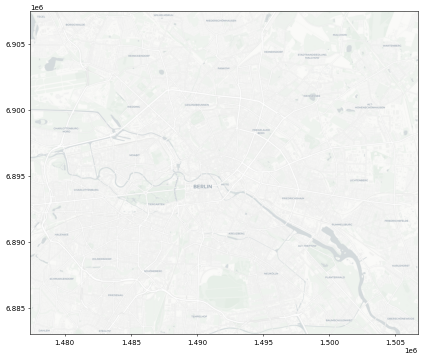

In [8]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
img, ext = cx.bounds2img(*bbox, ll=True, source=BASEMAP_SOURCE)
_ = ax.imshow(img, extent=ext)

for pair in input_pairs:
    input_df = gpd.GeoDataFrame(geometry=[Point(x,y) for x,y in pair], crs="EPSG:4326").to_crs("EPSG:3857")
    input_df.plot(ax=ax, **POINT_PLOT_KWDS)

_ = ax.axis("off")

Now we can call the `directions` endpoints for all routing engines. Note, that we use `get_router_by_name()` here. Alternatively, you can also import each routing class individually from `routingpy`.

We'll include popups for the plotted routes with `duration` and `distance` information.

In [9]:
dict_ = {"router": [], "distance": [], "duration": []}
geometries = []
for router in routers:
    
    api = get_router_by_name(router)(api_key=routers[router]['api_key'])
    
    for coords_pair in input_pairs:

        # just from A to B without intermediate points
        route = api.directions(
            profile=routers[router]['profile'],
            locations=coords_pair
        )
        # Access the route properties with .geometry, .duration, .distance
        distance, duration = route.distance / 1000, int(route.duration / 60)
        dict_["router"].append(router)
        dict_["distance"].append(distance)
        dict_["duration"].append(duration)
        geometries.append(LineString(route.geometry))
        
    print("Calulated {}".format(router))

routes_df = gpd.GeoDataFrame(dict_, geometry=geometries, crs="EPSG:4326").to_crs("EPSG:3857")

RouterApiError: 401 ({'error': 'Authorization field missing'})

NameError: name 'routes_df' is not defined

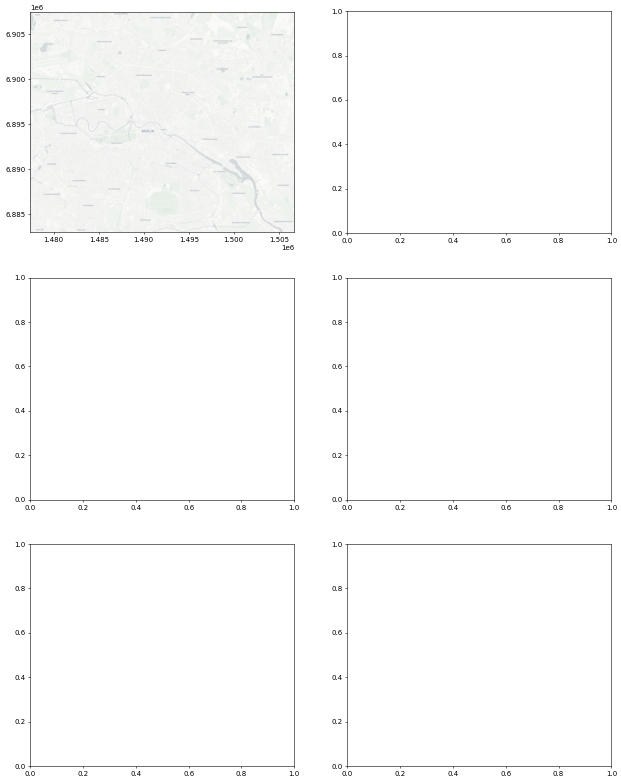

In [10]:
fig, axs = plt.subplots(3,2, figsize=(15,20))
img, ext = cx.bounds2img(*bbox, ll=True, source=BASEMAP_SOURCE)
for idx, router in enumerate(routers):
    ax = axs.flatten()[idx]
    _ = ax.imshow(img, extent=ext)
    routes_df.query(f"router == '{router}'").plot(
        ax=ax, linewidth=3, 
        color=routers[router]["color"]
    )
    for pair in input_pairs:
        input_df = gpd.GeoDataFrame(geometry=[Point(x,y) for x,y in pair], crs="EPSG:4326").to_crs("EPSG:3857")
        input_df.plot(ax=ax, **POINT_PLOT_KWDS)

    _ = ax.axis("off")
    ax.set_title(routers[router]['display_name'])

fig.tight_layout()

### Calculate Isochrones

First, let's create 2 random points in Berlin, which will serve as the center coordinate for our isochrones.

NameError: name 'gpd' is not defined

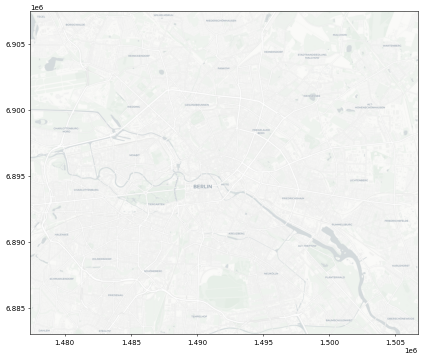

In [11]:
# coordinates for 2 locations
# distance for 1 degree in Berlin: ~ 110 km latitude, ~68 km longitude, 
# i.e. 6.8 km < distance < 13.4 km

input_isochrones = random_coordinates(n=2, min_dist=0.1, max_dist=0.2)

fig, ax = plt.subplots(1,1, figsize=(10,10))
_ = ax.imshow(img, extent=ext)

iso_input_df = gpd.GeoDataFrame(geometry=[Point(x,y) for x,y in input_isochrones], crs="EPSG:4326").to_crs("EPSG:3857")
iso_input_df.plot(ax=ax, **POINT_PLOT_KWDS)

_ = ax.axis("off")

Unfortunately, the `isochrones` methods are not as consistent as the other endpoints. Graphhopper does not allow for arbitrary ranges, while all others do. And Mapbox did the glorious decision to name their `isochrones` profiles different than their `directions` profiles. Here, it's interesting to note though, that their OSRM isochrone extension is not supported anymore and instead their isochrone endpoint runs on Valhalla (as you will see when you compare the Mapbox OSRM and Valhalla isochrones in the map below).

In [12]:
dict_ = {"router": [], "interval": [], "center": []}
isos = []
geometries = []
for router in routers:
    if routers[router]["isochrones"]:
        for location in input_isochrones:
            api = get_router_by_name(router)(api_key=routers[router]['api_key'])
                
            # Mapbox decided to call their isochrones profiles different from their directions profiles
            profile = routers[router].get('isochrones_profile') or routers[router]['profile']
            
            if router == 'graphhopper':
                isochrones = api.isochrones(
                    profile=profile,
                    # note: graphhopper just takes one interval which 
                    # can be split into equal buckets with the below parameter
                    intervals=[600],
                    buckets=3,
                    locations=location
                )
            else:
                isochrones = api.isochrones(
                    profile=profile,
                    intervals=[120,300,420,600],
                    locations=location,
                )
            
            isos.append({"router": router, "iso": isochrones})
            
            for idx, isochrone in reversed(list(enumerate(isochrones))):
                dict_["router"].append(router)
                dict_["interval"].append(isochrone.interval)
                dict_["center"].append(isochrone.center)
                if router == "heremaps":
                    geometries.append(MultiPolygon([Polygon(X) for X in isochrone.geometry]))
                else:
                    geometries.append(Polygon(isochrone.geometry))
                
        
        print("Calulated {}".format(router))
        
isochrones_df = gpd.GeoDataFrame(dict_, geometry=geometries, crs="EPSG:4326").to_crs("EPSG:3857")

RouterApiError: 401 ({'error': 'Authorization field missing'})

NameError: name 'isochrones_df' is not defined

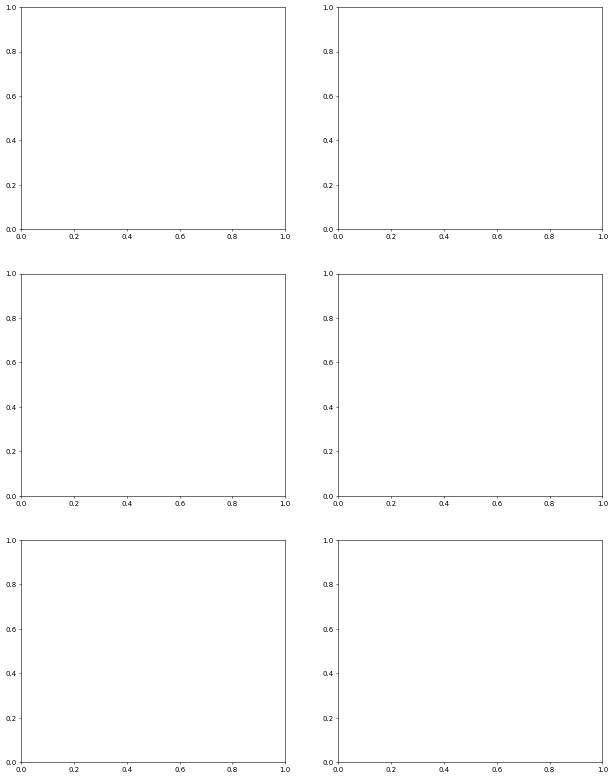

In [13]:
fig, axs = plt.subplots(3,2, figsize=(15,20))
iso_bbox = isochrones_df.to_crs("EPSG:4326").unary_union.bounds
img, ext = cx.bounds2img(*iso_bbox, ll=True, source=BASEMAP_SOURCE)
idx = 0
for router in routers:
    if routers[router]["isochrones"]:
        ax = axs.flatten()[idx]
        _ = ax.imshow(img, extent=ext)
        isochrones_df.query(f"router == '{router}'").plot(
            ax=ax, linewidth=1, facecolor=f'{routers[router]["color"]}{HEX_ALPHA}',
            edgecolor=routers[router]["color"]
        )
        iso_input_df.plot(ax=ax, **POINT_PLOT_KWDS)
        _ = ax.axis("off")
        ax.set_title(routers[router]["display_name"])
        idx += 1
fig.delaxes(axs[2,1])
fig.tight_layout()

### Calculate Matrix

Lastly, a quick intro how to calculate matrices. Again, first we'll generate random locations in Berlin. 10 locations is the limit for Google's "free" API, so we'll go with 10. 1 degree in Berlin equals ~110 km latitude and ~68 km longitude, so in order to get points that are between ~4 and ~10 km away from each other, we'll pass 0.05 and 0.1 degrees as distance thresholds.

NameError: name 'gpd' is not defined

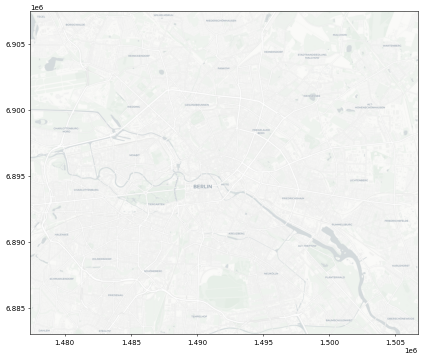

In [14]:
input_matrix = random_coordinates(n=10, min_dist=0.05, max_dist=0.1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
img, ext = cx.bounds2img(*bbox, ll=True, source=BASEMAP_SOURCE)
_ = ax.imshow(img, extent=ext)
matrix_df = gpd.GeoDataFrame(geometry=[Point(x,y) for x,y in input_matrix], crs="EPSG:4326").to_crs("EPSG:3857")
matrix_df.plot(ax=ax, **POINT_PLOT_KWDS)

_ = ax.axis("off")

In [12]:
durations = []

# First come up with the FROM & TO IDs
number_locations = len(input_matrix)
from_indices = list(chain.from_iterable([[x] * number_locations for x in range(number_locations)]))
to_indices = list(chain.from_iterable([[int(x) for x in range(number_locations)] for _ in range(number_locations)])
                 )
for idx, router in enumerate(routers):
    api = get_router_by_name(router)(api_key=routers[router]['api_key'])
    
    all_indices = list(range(len(input_matrix)))
    matrix = api.matrix(
        locations=input_matrix,
        sources=all_indices,
        destinations=all_indices,
        profile=routers[router]['profile']
    )
    
    print("Calulated {}".format(router))
    
    durations.append(list(chain.from_iterable(matrix.durations)))

# Transpose the matrix results to make them pandas friendly
transposed = [list(x) for x in zip(*durations)]

Calulated ors
Calulated mapbox_osrm
Calulated mapbox_valhalla
Calulated google
Calulated graphhopper
Calulated heremaps


Finally, we can print the results in a dataframe and inspect the differences. Note: the results are in seconds. 

**Spoiler alert**, they're bigger than you might expect...

In [13]:
matrix_df = pd.DataFrame(
    transposed,
    columns=[routers[router]["display_name"] for router in routers]
)
matrix_df.insert(0, 'TO_INDEX', to_indices)
matrix_df.insert(0, 'FROM_INDEX', from_indices)

matrix_df

,FROM_INDEX,TO_INDEX,OpenRouteService,MapBox (OSRM),MapBox (Valhalla),Google,GraphHopper,HereMaps
0,0,0,0.00,0.0,0,0,0,0
1,0,1,895.98,1373.5,1304,1304,971,1071
2,0,2,250.86,299.4,275,254,269,231
3,0,3,1215.79,1622.3,1482,1516,1218,1188
4,0,4,1114.37,1656.5,1520,1631,1136,1196
...,...,...,...,...,...,...,...,...
95,9,5,502.86,274.8,391,299,292,265
96,9,6,1632.32,1690.1,1607,1592,1461,1470
97,9,7,1522.27,1583.0,1466,1414,1244,1233
98,9,8,1299.79,1439.3,1307,1173,1055,1065


In [14]:
matrix_df.describe()

,FROM_INDEX,TO_INDEX,OpenRouteService,MapBox (OSRM),MapBox (Valhalla),Google,GraphHopper,HereMaps
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,4.500000,4.500000,905.234000,1124.623000,1084.850000,1053.710000,887.580000,866.390000
std,2.886751,2.886751,456.558709,576.276977,537.846611,532.432901,442.148592,436.657458
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,565.415000,695.925000,735.750000,644.500000,557.000000,549.500000
50%,4.500000,4.500000,992.765000,1276.700000,1243.500000,1236.000000,1001.500000,958.000000
75%,7.000000,7.000000,1265.822500,1574.150000,1490.250000,1441.500000,1189.250000,1157.250000
max,9.000000,9.000000,1632.320000,2162.000000,2094.000000,1941.000000,1670.000000,1679.000000
